#  A Synthetic Database of STEM Images of Some Crystals

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import temul.api as tml
import hyperspy.api as hs
import os
import cupy as cp
import time
from skimage import img_as_ubyte
from PIL import Image

In [2]:
def mkdir(p):
    if not os.path.exists(p):
        os.mkdir(p)

def link(src, dst):
    if not os.path.exists(dst):
        os.symlink(src, dst, target_is_directory=True)       

In [ ]:
#determine the path to the create directory to save images

path = os.getcwd()
os.makedirs(os.path.join(path, "random-lattices"), exist_ok = True) 
main_path = os.path.join(path, "random-lattices")
main_path

In [109]:
def cubic (sub_lattice,contrast, dim, num_x, dx, dy, sigma, dist):
    
    """ A function to create cubic lattice with one or two sublattices and one or two atom species
    
    Args:
        sub_lattice (int): Number of sublattices in the lattice. If 1, it is a single sublattice. If 2, it has 2 sublattices 
        one is equivalent to hexagonal for similar atoms.
        contrast (int): Contrast of the lattice. Range is in [20 120].
        dim (int): Dimension of the lattice. Range is in [800 1400].
        num_x (int): Number of unit cells along the x-axis. Range is in [40 100].
        dx (int): Displacement of the second sublattice along the x-axis.
        dy (int): Displacement of the second sublattice along the y-axis.
        sigma (float): Standard deviation of the Gaussian noise added to the lattice.
        dist (float): Introduce distortion by shifting horizontal rows.
    
    Returns:
        np.ndarray: Cubic Lattice
    """
    x, y = cp.mgrid[0:dim:num_x, 0:dim:num_x]
    x, y= x.flatten(), y.flatten()
       
    t_0 = tt.MakeTestData(dim, dim, sublattice_generate_image = False, add_row_scan_distortion = dist)
    t_0.add_atom_list(x.get(), y.get(), 3, 3, 80)

    sublattice_A   = t_0.sublattice
    atom_lattice_A = t_0.atom_lattice
    sublattice_A.construct_zone_axes()

    #Creating the second sublattice
    if sub_lattice == 2:

        x_1, y_1 = cp.mgrid[(num_x//2)+dx:dim:num_x, (num_x//2)+dy:dim:num_x]    # first quarter from top left, 
        
        x_12, y_12 = x_1.flatten(), y_1.flatten()
        
        x_12 = x_12 + abs(cp.random.randn(len(x_12)))
        y_12 = y_12 + abs(cp.random.randn(len(y_12)))
        
        x_12, y_12= x_12.get(), y_12.get()

        t_0.add_atom_list(x_12,y_12, 3, 3,contrast)  

    t_0.add_image_noise(sigma = sigma, only_positive=True)
    
    return t_0

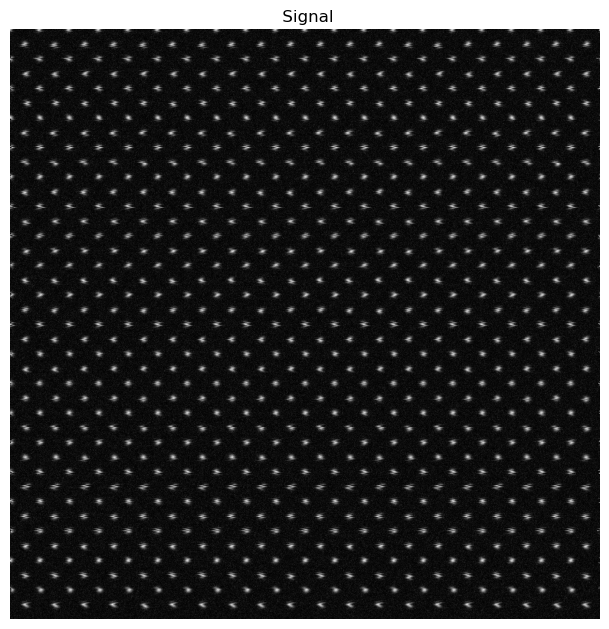

In [110]:
cubic_image = cubic(2, 80, 1000, 50, 0, 0, 0.1, 2.0)
cubic_image.signal.plot(colorbar=False, axes_off=True, scalebar= False )

In [97]:
image_counter=0
start = time.time()

for sub_lattice in [2]:  
    for contrast in [20, 40, 80]:  
        # This block defines the name of the folders to save the images. It defines 4 folders.  
        if sub_lattice == 1:
            if contrast := 80: folder_name= "cubic_2atom" 
        else:
            if contrast == 80:
                folder_name= "cubic_bcc"
            else:
                folder_name= "cubic_bcc_2atom"

        folder_root = Path(main_path) / folder_name
        folder_root.mkdir(exist_ok = True)
        
        for dim in [600,  1000]:
            for num_x in [40, 80]:
                for dx in [-2, 0,  2]:
                    for dy in [-2, 0, 2]:
                        for sigma in [  0.1, 0.3]:
                            for dist in [ 0.5, 1.5]:
                                # Load each image as Signal
                                sp=cubic(sub_lattice,contrast, dim, num_x, dx, dy, sigma, dist)

                                #Normalize signal and convert it to Uni8 in [0 255], then convert it to array 
                                sp_converted=Image.fromarray(img_as_ubyte(sp.signal.data/sp.signal.data.max()))
                                file_name = f"{folder_root}/S{sub_lattice}C{contrast}D{dim}N{num_x}dx{dx}dy{dy}Sg{sigma}dist{dist}.png"
                                file_path = folder_root/file_name
                                sp_converted.save(file_path, overwrite = True)

                                image_counter+=1
time_end=time.time()
print(f"total time is {(time_end-start)/60} minute and total number of created images is {image_counter*2}")

total time is 5.8366438547770185 minute and total number of created images is 864


### Build a Face or Body Centered Orthohrombic Lattices

In [78]:
def orthor (sub_lattice, contrast, atom_size, dim, num_x, dx, dy, sigma, dist):
    """ A function to create orthohrombic with based centered or face centered atoms.
    
    Args:
        sub_lattice (int): Number of sublattices in the lattice. If 1, it is a single sublattice. If 2, it has 2 sublattices 
        one is equivalent to hexagonal for similar atoms.
        contrast (int): Contrast of the lattice. Range is in [20 120].
        dim (int): Dimension of the lattice. Range is in [800 1000].
        num_x (int): Number of unit cells along the x-axis. Range is in [40 100].
        dx (int): Displacement of the second sublattice along the x-axis.
        dy (int): Displacement of the second sublattice along the y-axis.
        sigma (float): Standard deviation of the Gaussian noise added to the lattice.
        dist (float): Introduce distortion by shifting horizontal rows.
    
    Returns:
        np.ndarray: Orthohrombic lattice
    """
        
    x, y = cp.mgrid[0:dim:num_x/2, 0:dim:num_x]
    x, y = x.flatten(), y.flatten()
       
    t_0 = tt.MakeTestData(dim, dim, sublattice_generate_image=False, add_row_scan_distortion=dist)
    
    #Add atom size and contrast, e.g. 3 and 80. Heavier atoms need higher size/contrast.
    t_0.add_atom_list(x.get(), y.get(), 3,3, 80)

    #Creating the second sublattice, but different from tetragonal
    x_1, y_1 = cp.mgrid[-(num_x/4)+dx:dim:num_x/2, (num_x)+dy:dim:num_x]     
       
    if sub_lattice == 1:
        x_12, y_12 = x_1.flatten(), y_1.flatten()
        x_12= x_12 + abs(cp.random.randn(len(x_12)))
        y_12= y_12 + abs(cp.random.randn(len(y_12)))

        x_12, y_12= x_12.get(), y_12.get()
        
        t_0.add_atom_list(x_12,y_12, atom_size,atom_size ,contrast)  
               
    else:
        x_2, y_2 = cp.mgrid[-(num_x/4)+dx:dim:num_x/2, num_x/2+dy:dim:num_x]   
        
        x_112=cp.concatenate((x_1, x_2), axis=None)
        y_112=cp.concatenate((y_1, y_2), axis=None)
        
        x_112, y_112 = x_112.flatten(), y_112.flatten()
        x_112 = x_112 + abs(cp.random.randn(len(x_112)))
        y_112 = y_112 + abs(cp.random.randn(len(y_112)))

        x_112, y_112 = x_112.get(), y_112.get()
        
        t_0.add_atom_list(x_112, y_112, atom_size,atom_size ,contrast)  

    t_0.add_image_noise(sigma=sigma, only_positive=True)
    
    return t_0

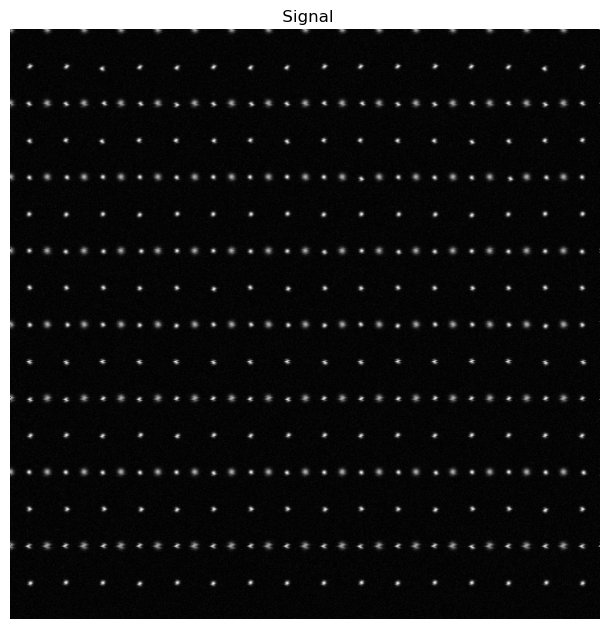

In [113]:
orthor_image = orthor(2, 50, 2, 800, 100, 0, 0, 0.05, 0.5)
orthor_image.signal.plot(colorbar=False, axes_off=True, scalebar= False )

In [81]:
image_counter=0
start = time.time()

for sub_lattice in [1, 2]:
    for atom_size in [2, 4]: 
        for contrast in [50, 150]:  
            if sub_lattice == 1:
                folder_name= "ortho_body_centered"
            else:
                folder_name= "ortho_face_centered"
        
            folder_root = Path(main_path)/folder_name
            folder_root.mkdir(exist_ok = True)            
                      
            for dim in [600, 1000]:
                for num_x in [50, 100]:
                    for dx in [-2, 2]:   # to increase number of images [-2, 0, 2]
                        for dy in [-2, 2]:
                            for sigma in [0.1, 0.3]:
                                for dist in [0.5, 1.5]:
                                    # Load each image as Signal
                                    sp=orthor(sub_lattice, contrast, atom_size, dim, num_x, dx, dy, sigma, dist)

                                    #Normalize signal and convert it to Uni8 in [0 255], then convert it to array 
                                    sp_converted=Image.fromarray(img_as_ubyte(sp.signal.data/sp.signal.data.max()))
                                    file_name = f"{folder_root}/S{atom_size}C{contrast}D{dim}N{num_x}dx{dx}dy{dy}Sg{sigma}dist{dist}.png"
                                    file_path = folder_root/file_name
                                    sp_converted.save(file_path, overwrite = True)

                                    image_counter+=1
time_end=time.time()
print(f"total time is {(time_end-start)/60} minute and total number of created images is {image_counter*2}")

total time is 1.4049638549486796 minute and total number of created images is 1024


### Build a tetragonal Lattice with centered atom in a-c plane

In [67]:
def tetragonal_centered (sub_lattice, contrast, dim, num_x, dx, dy, sigma, dist):
    
    """ A function to create tetragonal with centered atom in a-c plane, resulting in 3 different lattices.
    
    Args:
        Number of sublattices in the lattice (int): If 1, it is a single sublattice. If 2, it has 2 sublattices, one is 
        equivalent to hexagonal for similar atoms.
        contrast (int): Contrast of the lattice. Range is in [20 120].
        dim (int): Dimension of the lattice. Range is in [800 1000].
        num_x (int): Number of unit cells along the x-axis. Range is in [40 100].
        dx (int): Displacement of the second sublattice along the x-axis.
        dy (int): Displacement of the second sublattice along the y-axis.
        sigma (float): Standard deviation of the Gaussian noise added to the lattice.
        dist (float): Introduce distortion by shifting horizontal rows..
    
    Returns:
        np.ndarray: Tetragonal centered lattice.
    """
    x, y = cp.mgrid[0:dim:num_x, 0:dim:num_x/2]
    x, y = x.flatten(), y.flatten()
       
    t_0 = tt.MakeTestData(dim, dim, sublattice_generate_image=False, add_row_scan_distortion=dist)
    
    #Add atom size and contrast, e.g. 3 and 80. Heavier atoms need higher size/contrast.
    t_0.add_atom_list(x.get(), y.get(), 3, 3, 80)

    #Creating the second sublattice
    if sub_lattice == 2:

        x_1, y_1 = cp.mgrid[(num_x/2)+dx:dim:num_x, -(num_x/4)+dy:dim:num_x/2]     
       
        x_12, y_12 = x_1.flatten(), y_1.flatten()
        x_12 = x_12 + abs(cp.random.randn(len(x_12)))
        y_12 = y_12 + abs(cp.random.randn(len(y_12)))

        x_12, y_12= x_12.get(), y_12.get()
        
        t_0.add_atom_list(x_12, y_12, 3, 3 ,contrast)  

    t_0.add_image_noise(sigma = sigma, only_positive=True)
    
    return t_0

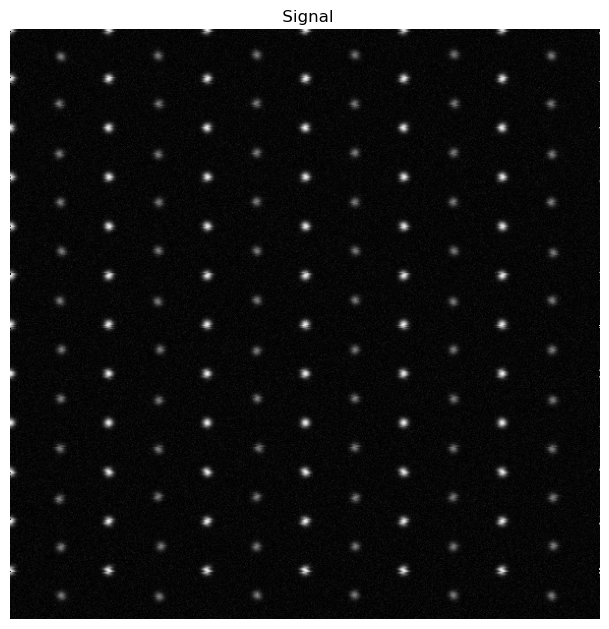

In [68]:
c = tetragonal_centered(2, 40, 600, 100, 0, 0, 0.05, .5)
c.signal.plot(colorbar = False, axes_off = True, scalebar = False )

In [104]:
image_counter=0
start = time.time()

for sub_lattice in [ 1, 2]:
    
    for contrast in [20, 80, 120]:  
        # This block defines the name of the folders to save the images. It defines 4 folders.  
        if sub_lattice == 1:
            folder_name = "teteragonal_c"
        else:
            if contrast == 80: folder_name= "teteragonal_body_center"
        
        folder_root = Path(main_path)/folder_name
        folder_root.mkdir(exist_ok = True)

        for dim in [600, 1000]:
            for num_x in [40, 80]:
                for dx in [-2, 2]:
                    for dy in [-2, 2]:
                        for sigma in [0.1, 0.4]:
                            for dist in [0.5, 1.5]:
                                # Load each image as Signal
                                sp=tetragonal_centered(sub_lattice,contrast, dim, num_x, dx, dy, sigma, dist)

                                #Normalize signal and convert it to Uni8 in [0 255], then convert it to array 
                                sp_converted=Image.fromarray(img_as_ubyte(sp.signal.data/sp.signal.data.max()))
                                
                                file_name = f"{folder_root}/S{sub_lattice}C{contrast}D{dim}N{num_x}dx{dx}dy{dy}Sg{sigma}dist{dist}.png"
                                file_path = folder_root/file_name
                                
                                sp_converted.save(file_path, overwrite = True)

                                image_counter+=1
time_end=time.time()
print(f"total time is {(time_end-start)/60} minute and total number of created images is {image_counter*2}")

total time is 2.0800598502159118 minute and total number of created images is 768


### Tetragonal with regular lattice

In [64]:
def tetragonal_regular (contrast, atom_size,  dim,  num_x, dx, dy, sigma, dist):

    """ A function to create two tetragonal sublattice displaced by c/2, a=b
    
    Args:
        contrast (int): Contrast of the lattice. Range is in [50 150].
        atom_size (int): Define the size of the atom in the second sublattice. Range is in [2 5].
        dim (int): Dimension of the lattice. Range is in [600 1400].
        num_x (int): Number of unit cells along the x-axis. Range is in [40 100].
        dx (int): Displacement of the second sublattice along the x-axis.
        dy (int): Displacement of the second sublattice along the y-axis.
        sigma (float): Standard deviation of the Gaussian noise added to the lattice.
        dist (float): Introduce distortion by shifting horizontal rows.
    
    Returns:
        np.ndarray: tetragonal_regular
    """
    x,y = cp.mgrid[0:dim:num_x, 0:dim:num_x//2]
    x, y= x.flatten(), y.flatten()
       
    t_0=tt.MakeTestData(dim,dim, sublattice_generate_image=False, add_row_scan_distortion=dist)
    
    #Add atom size and contrast, e.g. 3 and 80. Heavier atoms need higher size/contrast.
    t_0.add_atom_list(x.get(), y.get(), 3,3, 80)

    #Creating the second sublattice

    x_1, y_1 = cp.mgrid[(num_x//2)+dx:dim:num_x, dy:dim:num_x//2]    # first quarter from top left, 
       
    x_12, y_12 = x_1.flatten(), y_1.flatten()
    x_12 = x_12 + abs(cp.random.randn(len(x_12)))
    y_12 = y_12 + abs(cp.random.randn(len(y_12)))

    x_12, y_12 = x_12.get(), y_12.get()
        

    t_0.add_atom_list(x_12, y_12, atom_size, atom_size,contrast)  

    t_0.add_image_noise(sigma=sigma, only_positive=True)
    
    return t_0


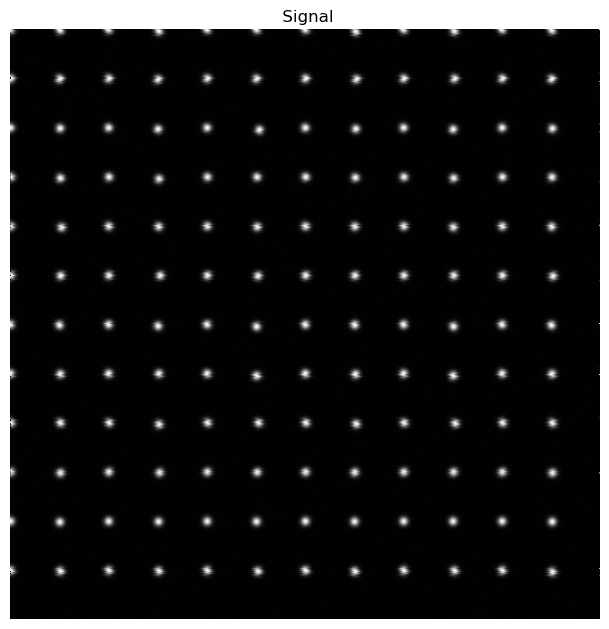

In [65]:
a=tetragonal_regular(80, 3, 600, 100, 0, 0, 0.01, 0.5)
a.signal.plot(colorbar=False, axes_off=True, scalebar= False )

In [98]:
image_counter=0
start = time.time()

for atom_size in [2,  5]:  #[2,3,5]
    for contrast in [50, 150]:  #[50,100,200]   
        
        folder_name= "teteragonal_reg_2atom"
        folder_root = Path(main_path)/folder_name
        folder_root.mkdir(exist_ok = True)
        
        for dim in [600,  1000]:
            for num_x in [50,  100]:
                for dx in [-2,   2]:
                    for dy in [-2,  2]:
                        for sigma in [  0.1, 0.3]:
                            for dist in [ 0.5, 1.5]:
                                # Load each image as Signal
                                sp=tetragonal_regular(contrast,atom_size,  dim,  num_x, dx, dy, sigma, dist)

                                #Normalize signal and convert it to Uni8 in [0 255], then convert it to array 
                                sp_converted=Image.fromarray(img_as_ubyte(sp.signal.data/sp.signal.data.max()))
                                file_name = f"{folder_root}/S{atom_size}C{contrast}D{dim}N{num_x}dx{dx}dy{dy}Sg{sigma}dist{dist}.png"
                                file_path = folder_root/file_name
                                sp_converted.save(file_path, overwrite = True)

                                image_counter+=1
time_end=time.time()
print(f"total time is {(time_end-start)/60} minute and total number of created images is {image_counter*2}")

total time is 1.2111938317616782 minute and total number of created images is 512


### Building a Face Centered Tetragonal Lattice

In [58]:
def tetragonal_face (sub_lattice, contrast, dim, num_x, dx, dy, sigma, dist):

    """ A function to create tetragonal lattice a=b, in a-c plane, with a sublattice twice larger along c. 
    
    Args:
        sub_lattice (int): Number of sublattices in the lattice. If 1, a single sublattice and if 2, it has 2 sublattices.
        contrast (int): Contrast of the lattice. Range is in [20 120].
        dim (int): Dimension of the lattice. Range is in [800 1000].
        num_x (int): Number of unit cells along the x-axis. Range is in [40 100].
        dx (int): Displacement of the second sublattice along the x-axis.
        dy (int): Displacement of the second sublattice along the y-axis.
        sigma (float): Standard deviation of the Gaussian noise added to the lattice.
        dist (float): Introduce distortion by shifting horizontal rows.
    
    Returns:
        np.ndarray: Tetragonal face lattice.
    """
    x, y = cp.mgrid[0:dim:num_x, 0:dim:num_x//2]
    x, y= x.flatten(), y.flatten()
       
    t_0 = tt.MakeTestData(dim, dim, sublattice_generate_image=False, add_row_scan_distortion=dist)
    t_0.add_atom_list(x.get(), y.get(), 3, 3, 80)

    #Creating the second sublattice
    if sub_lattice == 2:

        x_1, y_1 = cp.mgrid[(num_x//2)+dx:dim:num_x, dy:dim:num_x]    # first quarter from top left, 
       
        x_12, y_12 = x_1.flatten(), y_1.flatten()
        x_12 = x_12 + abs(cp.random.randn(len(x_12)))
        y_12 = y_12 + abs(cp.random.randn(len(y_12)))

        x_12, y_12= x_12.get(), y_12.get()      

        t_0.add_atom_list(x_12, y_12, 3, 3, contrast)  

    t_0.add_image_noise(sigma=sigma, only_positive=True)
    
    return t_0

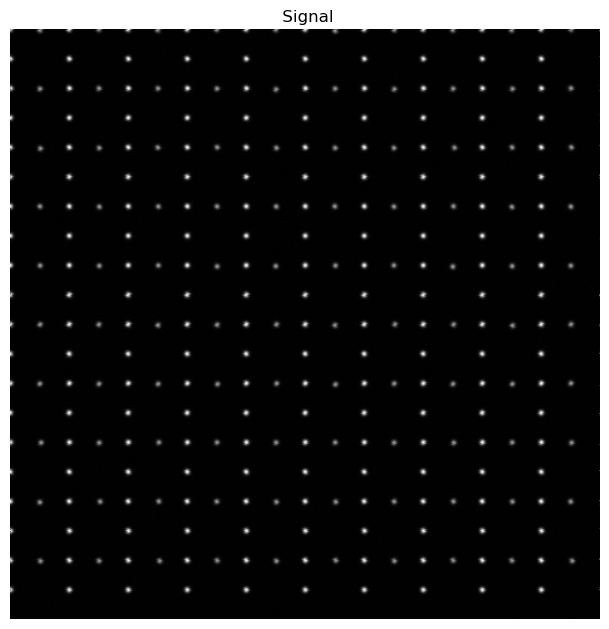

In [105]:
a=tetragonal_face(2, 50, 1000, 100, 0, 0, 0.01, .5)
a.signal.plot(colorbar=False, axes_off=True, scalebar= False )

In [106]:
image_counter=0
start = time.time()

for sub_lattice in [1, 2]: 
    for contrast in [50, 80]:  
        # This block defines the name of the folders to save the images. It defines 4 folders.  
        if sub_lattice == 1:
            folder_name= "teteragonal_face"         
        else:
            if contrast == 80:
                folder_name= "teteragonal_face_bcc"
            else:
                folder_name= "teteragonal_face_bcc_2atom"
        folder_root = Path(main_path)/folder_name
        folder_root.mkdir(exist_ok = True)
    
        for dim in [600, 1000]:
            for num_x in [40, 80]:
                for dx in [-2, 0,  2]:
                    for dy in [-2, 0, 2]:
                        for sigma in [0.1, 0.4]:
                            for dist in [0.5, 1.5]:
                                # Load each image as Signal
                                sp=tetragonal_face(sub_lattice,contrast, dim, num_x, dx, dy, sigma, dist)

                                #Normalize signal and convert it to Uni8 in [0 255], then convert it to array 
                                sp_converted=Image.fromarray(img_as_ubyte(sp.signal.data/sp.signal.data.max()))
                                file_name = f"{folder_root}/S{sub_lattice}C{contrast}D{dim}N{num_x}dx{dx}dy{dy}Sg{sigma}dist{dist}.png"
                                file_path = folder_root/file_name
                                sp_converted.save(file_path, overwrite = True)

                                image_counter+=1
time_end=time.time()
print(f"total time is {(time_end-start)/60} minute and total number of created images is {image_counter*2}")

total time is 2.6072153131167095 minute and total number of created images is 1152


### Build a hexagonal lattice

In [55]:
def hexagon_hex (contrast, dim, num_x, dx, dy, sigma, dist):

    """ A  function to create hexagonal lattice with  second sublattice, with one or two atom species. 
    
    Args:
        sub_lattice (int): Number of sublattices in the lattice. If 1, a single sublattice and if 2, it has 2 sublattices.
        contrast (int): Contrast 1 creates a haxonal lattice of one atom, 
        while contrast 2 creates two sublattice of different atoms.
        dim (int): Dimension of the lattice. Range is in [800 1000].
        num_x (int): Number of unit cells along the x-axis. Range is in [40 100].
        dx (int): Displacement of the second sublattice along the x-axis.
        dy (int): Displacement of the second sublattice along the y-axis.
        sigma (float): Standard deviation of the Gaussian noise added to the lattice.
        dist (float): Introduce distortion by shifting horizontal rows.
    
    Returns:
        np.ndarray: Hexagonal lattice.
    """   
    
    num_y = num_x / np.sqrt(3)  #this is equivalent to b axis 
    x_0, y_0 = cp.mgrid[0:dim:num_x, 0:dim:num_y]
    x_1, y_1 = cp.mgrid[num_x//2+dx:dim:num_x, num_y//2+dy:dim:num_y]

    x_01 = cp.concatenate((x_0, x_1), axis=None)
    y_01 = cp.concatenate((y_0, y_1), axis=None)

    x_01, y_01 = x_01.get(), y_01.get()
    
    t_0 = tt.MakeTestData(dim, dim, sublattice_generate_image=False, add_row_scan_distortion=dist)
    t_0.add_atom_list(x_01, y_01, 5, 5, 80)
    
    #To contruct the 2, 3 and 5, 6 pair of atoms of the same type
    x_2, y_2 = cp.mgrid[(num_x//3) +dx :dim:num_x, dy   :dim:num_y]    
    x_3, y_3 = cp.mgrid[(2*num_x//3)+dx:dim:num_x, dy   :dim:num_y]    
    
    x_4, y_4 = cp.mgrid[dx+5*num_x//6  :dim:num_x, (num_y//2)+dy:dim:num_y]    
    x_5, y_5 = cp.mgrid[dx+num_x//6    :dim:num_x, (num_y//2)+dy:dim:num_y]    
    
    x_12=cp.concatenate((x_2,  x_3, x_4, x_5), axis=None)
    y_12=cp.concatenate((y_2,  y_3, y_4, y_5), axis=None)

    x_12= x_12 + abs(cp.random.randn(len(x_12)))
    y_12= y_12 + abs(cp.random.randn(len(y_12)))
    
    x_12, y_12= x_12.get(), y_12.get()
    
    #Creating the second sublattice
    if contrast == 1:

        t_0.add_atom_list(x_12, y_12, 5, 5, 80)  
    else:
        t_0.add_atom_list(x_12, y_12, 4, 4, 20)  

    t_0.add_image_noise(sigma=sigma, only_positive=True)
             
    return t_0

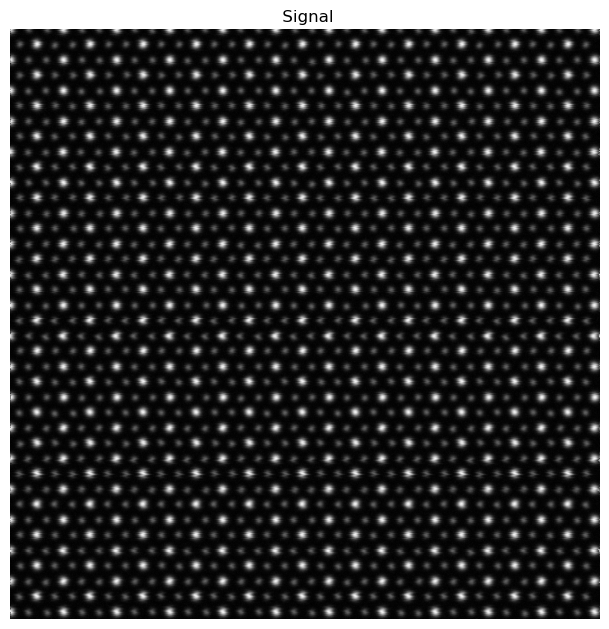

In [56]:
a=hexagon_hex(2, 1000, 90, 0, 0, 0.01, 1)
a.signal.plot(colorbar=False, axes_off=True, scalebar= False )

In [57]:
image_counter=0
start = time.time()
    
for contrast in [1, 2]:  
    if contrast == 1:
        folder_name= "hexagon"
    else:
        folder_name= "hexagon_2atom" 

    folder_root = Path(main_path)/folder_name
    folder_root.mkdir(exist_ok = True)

    for dim in [600,  800, 1000]:
        for num_x in [60, 80, 100]:
            for dx in [-2, 0,  2]:
                for dy in [-2, 0, 2]:
                    for sigma in [  0.1, 0.3]:
                        for dist in [ 0.5, 1.5]:
                            # Load each image as Signal
                            sp=hexagon_hex(contrast, dim, num_x, dx, dy, sigma, dist)

                            #Normalize signal and convert it to Uni8 in [0 255], then convert it to array 
                            sp_converted=Image.fromarray(img_as_ubyte(sp.signal.data/sp.signal.data.max()))
                            file_name = f"{folder_root}/C{contrast}D{dim}N{num_x}dx{dx}dy{dy}Sg{sigma}dist{dist}.png"
                            file_path = folder_root/file_name
                            sp_converted.save(file_path, overwrite = True)
                            
                            image_counter+=1
time_end=time.time()
print(f"total time is {(time_end-start)/60} minute and total number of created images is {image_counter*2}")

total time is 2.4783620635668435 minute and total number of created images is 1296


### Build a Trigonal Lattice

In [114]:
def rhombohedral (contrast, atom_size, dim, num_x, dx,  sigma, dist):
    
    """ A  function to create trigonal structure with one or two atoms (Rhombohedral, a=b=c, alpha=beta=gamma) 
    
    Args:
        atom_size (int): Define the size of the atom in the second sublattice. Range is in [2 4].
        contrast (int): Contrast 1 creates a haxonal lattice of one atom, while contrast 2 creates two sublattice of 
        different atoms.
        dim (int): Dimension of the lattice. Range is in [800 1000].
        num_x (int): Number of unit cells along the x-axis. Range is in [40 100].
        dx (int): Displacement of the second sublattice along the x-axis.
        dy (int): Displacement of the second sublattice along the y-axis.
        sigma (float): Standard deviation of the Gaussian noise added to the lattice.
        dist (float): Introduce distortion by shifting horizontal rows.
    
    Returns:
        np.ndarray: rhombohedral lattice.
    """   
    x, y = cp.mgrid[0:dim:num_x//2, 0:dim:num_x]
    x, y = x.flatten(), y.flatten()
       
    t_0 = tt.MakeTestData(dim, dim, sublattice_generate_image=False, add_row_scan_distortion=dist)
    t_0.add_atom_list(x.get(), y.get(), atom_size,atom_size, contrast)

    #Creating the second sublattice
    x_1, y_1 = cp.mgrid[num_x//8+dx:dim:num_x//2, num_x//2:dim:num_x]    # defining some angle for alpha 

    x_12, y_12 = x_1.flatten(), y_1.flatten()
    x_12 = x_12 + abs(cp.random.randn(len(x_12)))
    y_12 = y_12 + abs(cp.random.randn(len(y_12)))

    x_12, y_12= x_12.get(), y_12.get()

    t_0.add_atom_list(x_12, y_12, atom_size, atom_size, contrast)  

    t_0.add_image_noise(sigma=sigma, only_positive=True)
    
    return t_0

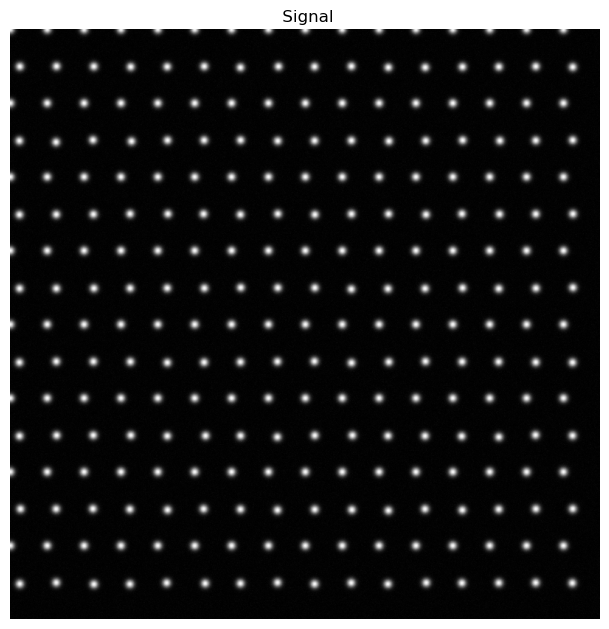

In [116]:
a=rhombohedral (80, 4 , 800, 100, 0, 0.01, 0.03)
a.signal.plot(colorbar=False, axes_off=True, scalebar= False )

In [54]:
image_counter=0

start = time.time()

folder_name= "triclinic_rhomboh"      
folder_root = Path(main_path)/folder_name
folder_root.mkdir(exist_ok = True)

for contrast in [20, 80]:
    for atom_size in [2, 4]:
        for dim in [600,  1000]:
            for num_x in [50, 100]:
                for dx in [-2,   2]:
                    for dy in [-2, 2]:
                        for sigma in [  0.1, 0.4]:
                            for dist in [ 0.5, 1.5]:
                                # Load each image as Signal
                                sp=rhombohedral(contrast, atom_size, dim, num_x, dx,  sigma, dist)

                                #Normalize signal and convert it to Uni8 in [0 255], then convert it to array 
                                sp_converted=Image.fromarray(img_as_ubyte(sp.signal.data/sp.signal.data.max()))
                                
                                file_name = f"{folder_root}/S{atom_size}C{contrast}D{dim}N{num_x}dx{dx}dy{dy}Sg{sigma}dist{dist}.png"
                                file_path = folder_root/file_name
                                
                                sp_converted.save(file_path, overwrite = True)

                                image_counter+=1

time_end=time.time()
print(f"total time is {(time_end-start)/60} minute and total number of created images is {image_counter*2}")

total time is 0.5461731354395548 minute and total number of created images is 512
